In [155]:
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

## Problem 1

For Z channel of input probability $p(X=1) = p$, error probability $f = 0.5$
$$
\begin{aligned}
I(X;Y) &= H(Y) - H(Y|X) \\
&= H_2((1-f)p) - pH_2(f) \\
&= H_2(0.5p) - pH_2(0.5) \\
&= H_2(0.5p) - p
\end{aligned}
$$
Take derivative wrt. p and let it be zero, we get
$$
p^* = 0.4
$$
Thus the capacity of this channel is only achieved when $p(X=1) = 0.4$. The input with $p(X=1)=0.5$ failed to do that. And the maximum rate this input can achieve is indicated by the mutual information
$$
I(X;Y) = H_2(0.25) - 0.5 = 0.31
$$

## Problem 2

In [156]:
test_seq = ''.join(map(str, stats.bernoulli.rvs(p=0.5, size=10000)))
def random_coding(N, K, seq):
    if 10000 % K != 0:
        return None
    listK = [seq[i:(i + K)] for i in xrange(0, 10000 - K + 1, K)]
    setK = set(listK)
    cntK = len(setK)
    codes = stats.bernoulli.rvs(p=0.5, size=(cntK, N))
    codebook = {}
    i = 0
    for block in setK:
        code_str = ''.join(map(str, codes[i]))
        codebook[block] = codes[i]
        i += 1
    return codebook, np.array([codebook[s] for s in listK])

def transmit(seq_enc, f=0.1):
    noise = stats.bernoulli.rvs(f, size=seq_enc.shape)
    return np.logical_xor(seq_enc, noise).astype('int')

def typical_decode(seq_recv, codebook, f):
    seq_dec = ''
    for i in xrange(seq_recv.shape[0]):
        min_ = 1000
        res = None
        for k, v in codebook.iteritems():
            diff = np.abs((v != seq_recv[i]).sum() - v.shape[0]*f)
            if diff < min_:
                min_ = diff
                res = k
        seq_dec += res
    return seq_dec

def error(N, K):
    f = 0.1
    codebook, seq_enc = random_coding(N, K, test_seq)
    seq_recv = transmit(seq_enc, f=f)
    seq_dec = typical_decode(seq_recv, codebook, f=f)
    seq_block = np.array(map(int, test_seq)).reshape((-1, K))
    seq_dec_block = np.array(map(int, seq_dec)).reshape((-1, K))
    check = (seq_block != seq_dec_block)
    bit_error = check.sum() * 1. / len(test_seq)
    block_error = np.any(check, axis=1).sum() * 1. / check.shape[0]
    return bit_error, block_error

N = [20, 100, 40, 100, 50, 100]
K = [10, 10, 20, 20, 25, 25]
for i in xrange(len(N)):
    pb, pB = error(N[i], K[i])
    print 'N=%d, K=%d: Pb=%s, PB=%s' % (N[i], K[i], pb, pB)

N=20, K=10: Pb=0.2014, PB=0.402
N=100, K=10: Pb=0.0, PB=0.0
N=40, K=20: Pb=0.0034, PB=0.008
N=100, K=20: Pb=0.0, PB=0.0
N=50, K=25: Pb=0.0, PB=0.0
N=100, K=25: Pb=0.0, PB=0.0


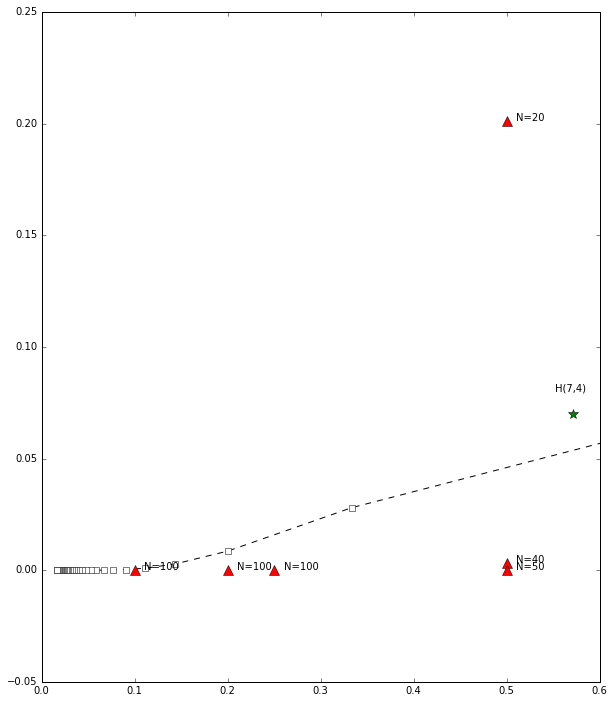

In [157]:
from scipy.misc import comb

def perror(N, f):
    return np.sum([comb(N, n) * f**n * (1. - f)**(N - n)
                   for n in xrange((N+1)/2, N+1)])
reps = np.arange(1, 62, 2)
rates = 1. / reps
plt.figure(figsize=(10,12))
_ = plt.plot(rates, map(lambda x: perror(x, 0.1), reps), 'ks--', markerfacecolor='w')
typical_rates = [0.5, 0.1, 0.5, 0.2, 0.5, 0.25]
pb = [0.2014, 0.0, 0.0034, 0.0, 0.0, 0.0]
label = ['N=20', 'N=100', 'N=40', 'N=100', 'N=50', 'N=100']
for i in xrange(6):
    plt.plot(typical_rates[i], pb[i], 'r^', markersize=10)
    plt.text(typical_rates[i] + 0.01, pb[i], label[i])
# plt.yscale('log')
plt.plot(4./7, 0.07, 'g*', markersize=10)
plt.text(4./7 - 0.02, 0.08, 'H(7,4)')
_ = plt.ylim([-0.05, 0.25])
_ = plt.xlim([0.0, 0.6])

We can see that with large $N$, the random coding and typical set decoding can always achieve near-zero error when the rate is less than capacity $C=0.53$.